In [1]:
import sys, os
BIN = os.path.abspath("../../..")
sys.path.append(BIN)

from scipy.special import erfc, wofz

import numpy as np
from scipy.constants import m_p, c, e, epsilon_0, pi

import PyHEADTAIL.spacecharge.spacecharge as sc
from PyHEADTAIL.particles.particles import Particles
from PyHEADTAIL.particles import generators, slicing
from PyHEADTAIL.spacecharge.spacecharge import TransverseGaussianSpaceCharge

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(0)

PyHEADTAIL v1.6.0.107




In [2]:
# general simulation parameters
n_turns = 20000
n_particles = 10000
n_segments = 1

# machine parameters
circumference = 157.
inj_alpha_x = 0
inj_alpha_y = 0
inj_beta_x = 6.3 # in [m]
inj_beta_y = 5.7 # in [m]
Qx = 5.1
Qy = 6.1
gamma_tr = 4.05
alpha_c_array = [gamma_tr**-2]
V_rf = 8e3 # in [V]
harmonic = 1
phi_offset = 0 # measured from aligned focussing phase (0 or pi)
pipe_radius = 5e-2

# beam parameters
Ekin = 1.4e9 # in [eV]
intensity = 1.684e12
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
epsn_z = 1.2 # 4pi*sig_z*sig_dp (*p0/e) in [eVs]

# calculations
gamma = 1 + e * Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
eta = alpha_c_array[0] - gamma**-2
if eta < 0:
    phi_offset = np.pi - phi_offset
Etot = gamma * m_p * c**2 / e
p0 = np.sqrt(gamma**2 - 1) * m_p * c
Qs = np.sqrt(np.abs(eta) * V_rf / (2 * np.pi * beta**2 * Etot))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)
turn_period = circumference / (beta * c)

# BETATRON
# Loop on number of segments and create the TransverseSegmentMap
# for each segment.
s = np.arange(0, n_segments + 1) * circumference / n_segments
alpha_x = inj_alpha_x * np.ones(n_segments)
beta_x  = inj_beta_x * np.ones(n_segments)
D_x     = np.zeros(n_segments)
alpha_y = inj_alpha_y * np.ones(n_segments)
beta_y  = inj_beta_y * np.ones(n_segments)
D_y     = np.zeros(n_segments)

In [3]:
bunch = generators.generate_Gaussian6DTwiss( 
    # implicitly tests Gaussian and Gaussian2DTwiss as well
    n_particles, intensity, e, m_p, circumference, gamma,
    inj_alpha_x, inj_alpha_y,
    inj_beta_x, inj_beta_y, beta_z,
    epsn_x, epsn_y, epsn_z,
    )
slicer = slicing.UniformBinSlicer(20, n_sigma_z=4)
besc = TransverseGaussianSpaceCharge(slicer, circumference)

In [5]:
slices = bunch.get_slices(slicer, statistics=["mean_x", "mean_y", "sigma_x", "sigma_y"])

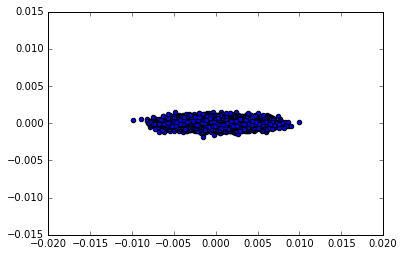

In [6]:
xp0 = bunch.xp.copy()
yp0 = bunch.yp.copy()
plt.scatter(bunch.x, xp0)
plt.show()

In [7]:
print bunch.sigma_x(), bunch.sigma_y()

0.00259419344878 0.0024917889254


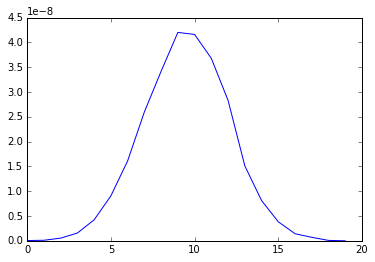

In [8]:
plt.plot(slices.lambda_bins(smoothen=False))

In [9]:
besc.track(bunch)
xp1 = bunch.xp
yp1 = bunch.yp

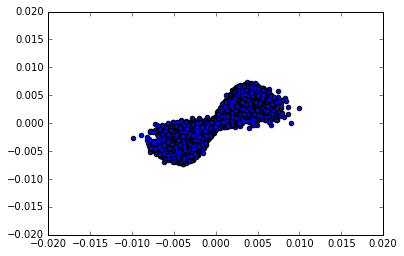

In [10]:
plt.scatter(bunch.x, xp1)
plt.show()

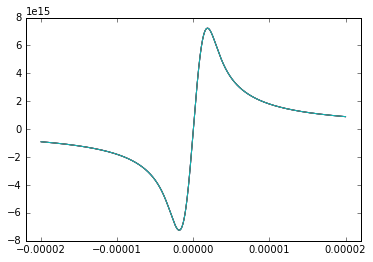

In [11]:
x = np.arange(-2e-5, 2e-5, 1e-8)
y = np.zeros(len(x))
sig_x = 1.2e-6
sig_y = 1e-6

plt.plot(x, besc._efieldn_mit(x, y, sig_x, sig_y)[0])
plt.plot(x, besc._efieldn_mitmod(x, y, sig_x, sig_y)[0])
try:
    plt.plot(x, besc._efieldn_koelbig(x, y, sig_x, sig_y)[0])
    plt.plot(x, besc._efieldn_pyecloud(x, y, sig_x, sig_y)[0])
except ImportError:
    pass
plt.xlim(x[0]*1.1, x[-1]*1.1)
plt.show()

In [12]:
%timeit besc._efieldn_mit(x, y, sig_x, sig_y)

1000 loops, best of 3: 821 µs per loop


In [13]:
%timeit besc._efieldn_mitmod(x, y, sig_x, sig_y)

1000 loops, best of 3: 1.38 ms per loop


In [14]:
%timeit besc._efieldn_koelbig(x, y, sig_x, sig_y)

100 loops, best of 3: 5.58 ms per loop


In [15]:
%timeit besc._efieldn_pyecloud(x, y, sig_x, sig_y)

100 loops, best of 3: 5.87 ms per loop


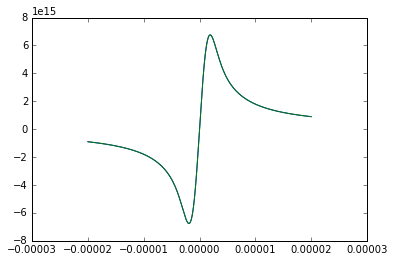

In [16]:
eround_x, _ = besc.get_efieldn(x, y, 0, 0, sig_x, sig_x)
en_x, _ = besc.get_efieldn(x, y, 0, 0, sig_x, sig_x+1e-10)
plt.plot(x, eround_x)
plt.plot(x, en_x)
plt.show()